In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import datetime

# Load the dataset
data = pd.read_csv(r"C:\Users\Windows\Downloads\forecasting-unit-sales-vit-task-2\train.csv")
# Print column names to find the correct name for the date column
print(data.columns)

# If needed, you can also print the first few rows to get an idea of the data
print(data.head())

# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Initial inspection
print(data.head())
print(data.info())


Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id', 'units',
       'unit_price'],
      dtype='object')
                      ID        date     Item Id  \
0  2022-04-12_B09KDTS4DC  2022-04-12  B09KDTS4DC   
1  2022-04-12_B09MR2MLZH  2022-04-12  B09MR2MLZH   
2  2022-04-12_B09KSYL73R  2022-04-12  B09KSYL73R   
3  2022-04-12_B09KT5HMNY  2022-04-12  B09KT5HMNY   
4  2022-04-12_B09KTF8ZDQ  2022-04-12  B09KTF8ZDQ   

                                           Item Name  ad_spend anarix_id  \
0  NapQueen Elizabeth 8" Gel Memory Foam Mattress...       NaN  NAPQUEEN   
1  NapQueen 12 Inch Bamboo Charcoal Queen Size Me...       NaN  NAPQUEEN   
2     NapQueen Elsa 8" Innerspring Mattress, Twin XL       NaN  NAPQUEEN   
3        NapQueen Elsa 6" Innerspring Mattress, Twin       NaN  NAPQUEEN   
4     NapQueen Elsa 6" Innerspring Mattress, Twin XL       NaN  NAPQUEEN   

   units  unit_price  
0    0.0         0.0  
1    0.0         0.0  
2    0.0         0.0  
3    0.0       

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


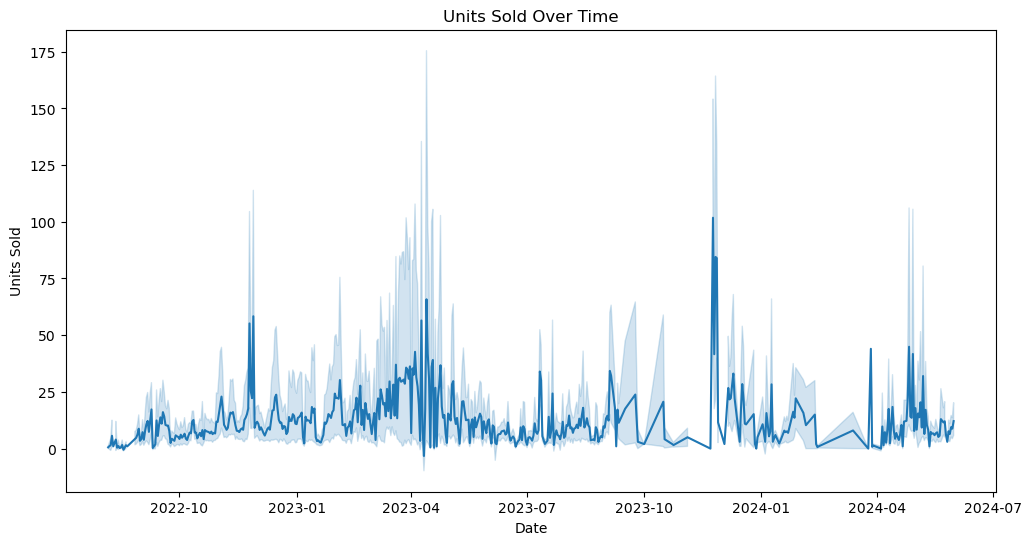

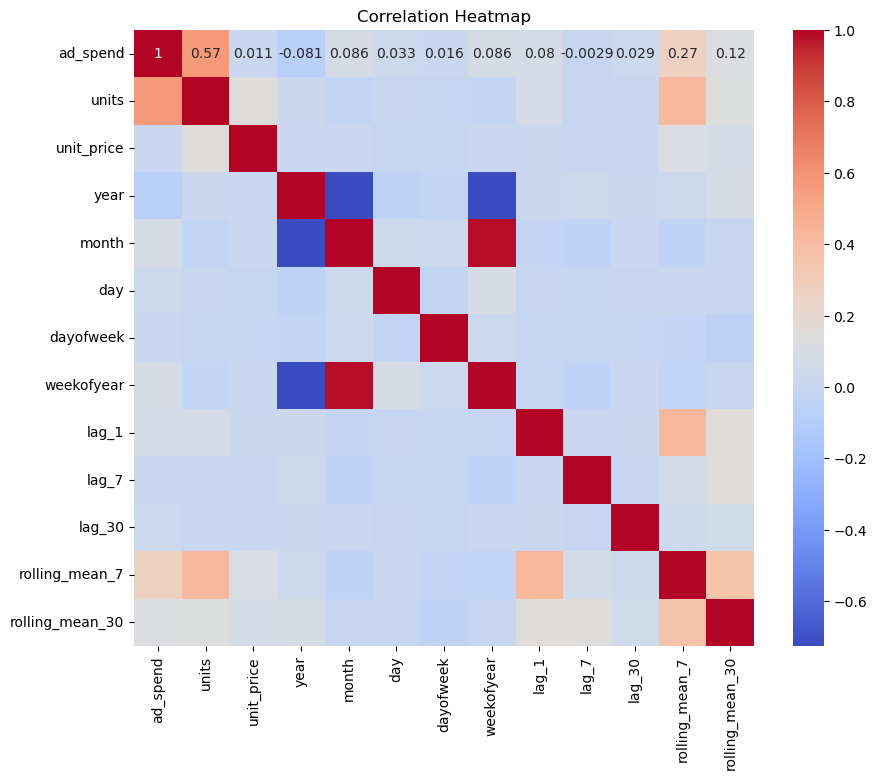

In [10]:
# # EDA: Plotting sales over time
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='date', y='units', data=data)
# plt.title('Units Sold Over Time')
# plt.xlabel('Date')
# plt.ylabel('Units Sold')
# plt.show()

# # Correlation heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
# plt.show()
# EDA: Plotting sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='units', data=data)
plt.title('Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

# Selecting only numeric columns for correlation heatmap
numeric_data = data.select_dtypes(include=[np.number])

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [11]:
# Extract date features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek
data['weekofyear'] = data['date'].dt.isocalendar().week.astype(int)

# Lag features
data['lag_1'] = data['units'].shift(1)
data['lag_7'] = data['units'].shift(7)
data['lag_30'] = data['units'].shift(30)

# Rolling mean features
data['rolling_mean_7'] = data['units'].rolling(window=7).mean()
data['rolling_mean_30'] = data['units'].rolling(window=30).mean()

# Drop rows with NaN values created by shifting and rolling
data = data.dropna()

# Select features and target variable
features = ['year', 'month', 'day', 'dayofweek', 'weekofyear', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_mean_30', 'ad_spend', 'unit_price']
target = 'units'

X = data[features]
y = data[target]


C:\Users\Windows\AppData\Local\Temp\ipykernel_30232\2661549456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['date'].dt.year
C:\Users\Windows\AppData\Local\Temp\ipykernel_30232\2661549456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data['date'].dt.month
C:\Users\Windows\AppData\Local\Temp\ipykernel_30232\2661549456.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Mean Squared Error: 845.0670308741104


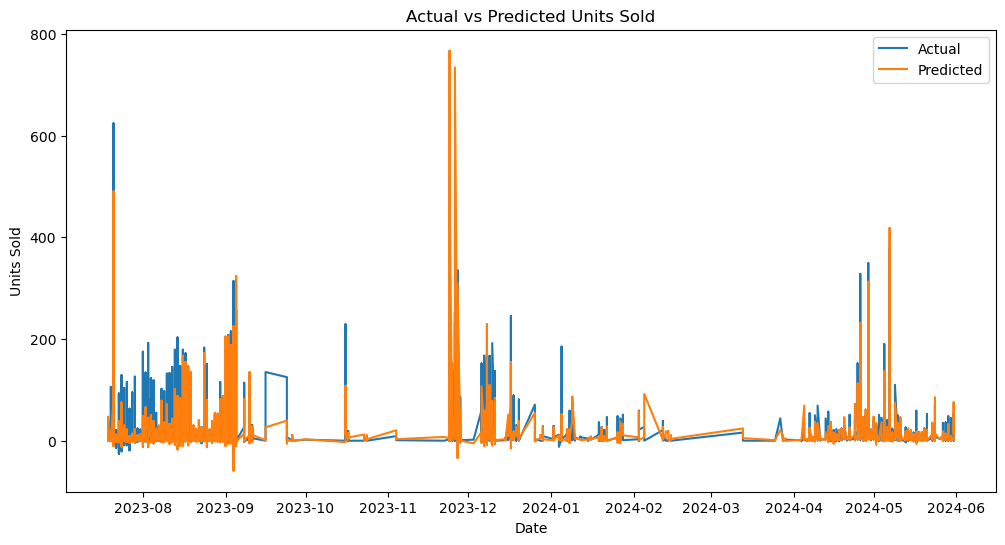

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(data['date'][-len(y_test):], y_test, label='Actual')
plt.plot(data['date'][-len(y_test):], y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()


In [7]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predictions with best model
y_pred_best = best_model.predict(X_test)

# Evaluation
mse_best = mean_squared_error(y_test, y_pred_best)
print(f'Best Model Mean Squared Error: {mse_best}')


Best Model Mean Squared Error: 868.8594398026198


In [9]:
# Prepare submission file
submission = pd.DataFrame({
    'date': data['date'][-len(y_test):],
    'item_id': data['Item Id'][-len(y_test):],
    'units_sold_predicted': y_pred_best
})

# Save to CSV
submission.to_csv(r"C:\Users\Windows\Downloads\sample_submission.csv", index=False)
